In [26]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import missingno as msno
import pycountry

os.environ["MODIN_ENGINE"] = "ray"  # Modin will use Ray

# import pandas as pd
import modin.pandas as pd
import ray
ray.init(ignore_reinit_error=True)

from scipy import stats

import warnings
warnings.filterwarnings("ignore")

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import *

2021-11-16 20:44:40,343	INFO worker.py:832 -- Calling ray.init() again after it has already been called.


In [27]:
%run ./module_P2_utils.ipynb

In [28]:
df = pd.read_csv("./tmp/df_01_cleaned.csv")

# ANALYSIS

Main features that we'll anaylise below :

| Feature | Type |
|-----|-----|
code	                | object	            |0.000000
states	                | object	            |0.000000
states_en	            | object	            |0.000000
states_tags	            | object	            |0.000000
created_datetime	    | datetime64[ns, UTC]	|0.000000
last_modified_datetime	| datetime64[ns, UTC]	|0.000000
creator	                | object	            |0.000201
pnns_groups_2	        | object	            |0.009807
pnns_groups_1	        | object	            |0.009907
countries	            | object	            |0.307572
countries_tags	        | object	            |0.307824
countries_en	        | object	            |0.307824
product_name	        | object	            |4.101583
energy_100g	            | float64               |20.664821
proteins_100g	        | float64               |21.001209
fat_100g	            | float64               |21.063015
carbohydrates_100g	    | float64               |21.081069
sugars_100g	            | float64               |21.867249
saturated-fat_100g	    | float64               |23.229649
energy-kcal_100g	    | float64               |23.248005
salt_100g	            | float64               |25.224544
sodium_100g	            | float64               |25.224695


In particular, let's investigate pnns_groups_1 & pnns_groups_2 [PNNS website](https://www.mangerbouger.fr/PNNS) related to:

* energy_100g
* proteins_100g
* fat_100g
* carbohydrates_100g
* sugars_100g
* saturated-fat_100g
* energy-kcal_100g
* salt_100g
* sodium_100g

First, we need to check for existing outliers, and remove them in order to get a good analysis afterwards

## Outliers analysis

### Outliers for Quantitative Values

In [37]:
quantis = df.select_dtypes('float').columns
quantis

Index(['additives_n', 'ingredients_from_palm_oil_n',
       'ingredients_that_may_be_from_palm_oil_n', 'nutriscore_score',
       'nova_group', 'energy-kcal_100g', 'energy_100g', 'fat_100g',
       'saturated-fat_100g', 'carbohydrates_100g', 'sugars_100g',
       'proteins_100g', 'salt_100g', 'sodium_100g', 'nutrition-score-fr_100g'],
      dtype='object')

In [39]:
modes = getMultiModes(df, quantis)
modes

[False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False]

All our features have only one mode, we may expect them to follow a normal distribution, but we need to analyse deeper

In [31]:
pd.options.display.float_format = '{:,.2f}'.format

In [40]:
df[quantis].agg(agg_func).T

,std,skew,kurtosis,mean,median,var,mad,prod,sum
additives_n,3.23,2.31,7.79,2.45,1.00,10.41,2.33,0.00,"894,914.00"
ingredients_from_palm_oil_n,0.19,5.26,27.30,0.04,0.00,0.04,0.07,0.00,"12,874.00"
ingredients_that_may_be_from_palm_oil_n,0.38,4.31,23.46,0.11,0.00,0.14,0.20,0.00,"39,057.00"
nutriscore_score,8.83,0.01,-1.00,10.65,12.00,77.89,7.57,0.00,"4,836,342.00"
nova_group,0.76,-2.38,5.24,3.63,4.00,0.57,0.55,inf,"1,200,161.00"
energy-kcal_100g,"52,042.30",925.14,"863,187.18",367.21,300.00,"2,708,400,876.82",217.16,NaN,"323,559,782.38"
energy_100g,"213,100.71",943.65,"898,132.18","1,520.45","1,247.00","45,411,914,705.51",897.63,NaN,"1,394,134,230.30"
fat_100g,14.44,1.35,2.30,15.53,11.60,208.58,11.47,inf,"14,243,881.67"
saturated-fat_100g,7.26,2.31,9.29,6.08,3.20,52.67,5.38,inf,"5,578,555.18"
carbohydrates_100g,26.01,0.48,-1.17,29.53,21.43,676.27,23.28,inf,"27,085,846.59"


In [41]:
df[quantis].describe().T

,count,mean,std,min,25%,50%,75%,max
additives_n,"364,757.00",2.45,3.23,0.00,0.00,1.00,4.00,39.00
ingredients_from_palm_oil_n,"364,757.00",0.04,0.19,0.00,0.00,0.00,0.00,3.00
ingredients_that_may_be_from_palm_oil_n,"364,757.00",0.11,0.38,0.00,0.00,0.00,0.00,6.00
nutriscore_score,"454,252.00",10.65,8.83,-14.00,3.00,12.00,17.00,40.00
nova_group,"330,566.00",3.63,0.76,1.00,3.00,4.00,4.00,4.00
energy-kcal_100g,"881,137.00",367.21,"52,042.30",0.00,154.00,300.00,434.70,"48,600,000.00"
energy_100g,"916,925.00","1,520.45","213,100.71",0.00,633.00,"1,247.00","1,813.00","203,000,000.00"
fat_100g,"917,304.00",15.53,14.44,0.00,3.60,11.60,24.00,99.92
saturated-fat_100g,"917,304.00",6.08,7.26,0.00,1.00,3.20,8.90,99.00
carbohydrates_100g,"917,304.00",29.53,26.01,0.00,4.90,21.43,53.50,99.90


Definitively, some features contains outliers, especially for instance `energy_100g` : std and range are very high

Documentation says : *"- fields that end with _100g correspond to the amount of a nutriment (in g, or kJ for energy) for 100 g or 100 ml of product"*

Also we should assume for some of the features, and all of the *_100g features:

* mustn't be negative or superior to 100
* if a value is NaN, we may replace by 0.

Then, let's see graphically the distribution using box plots.

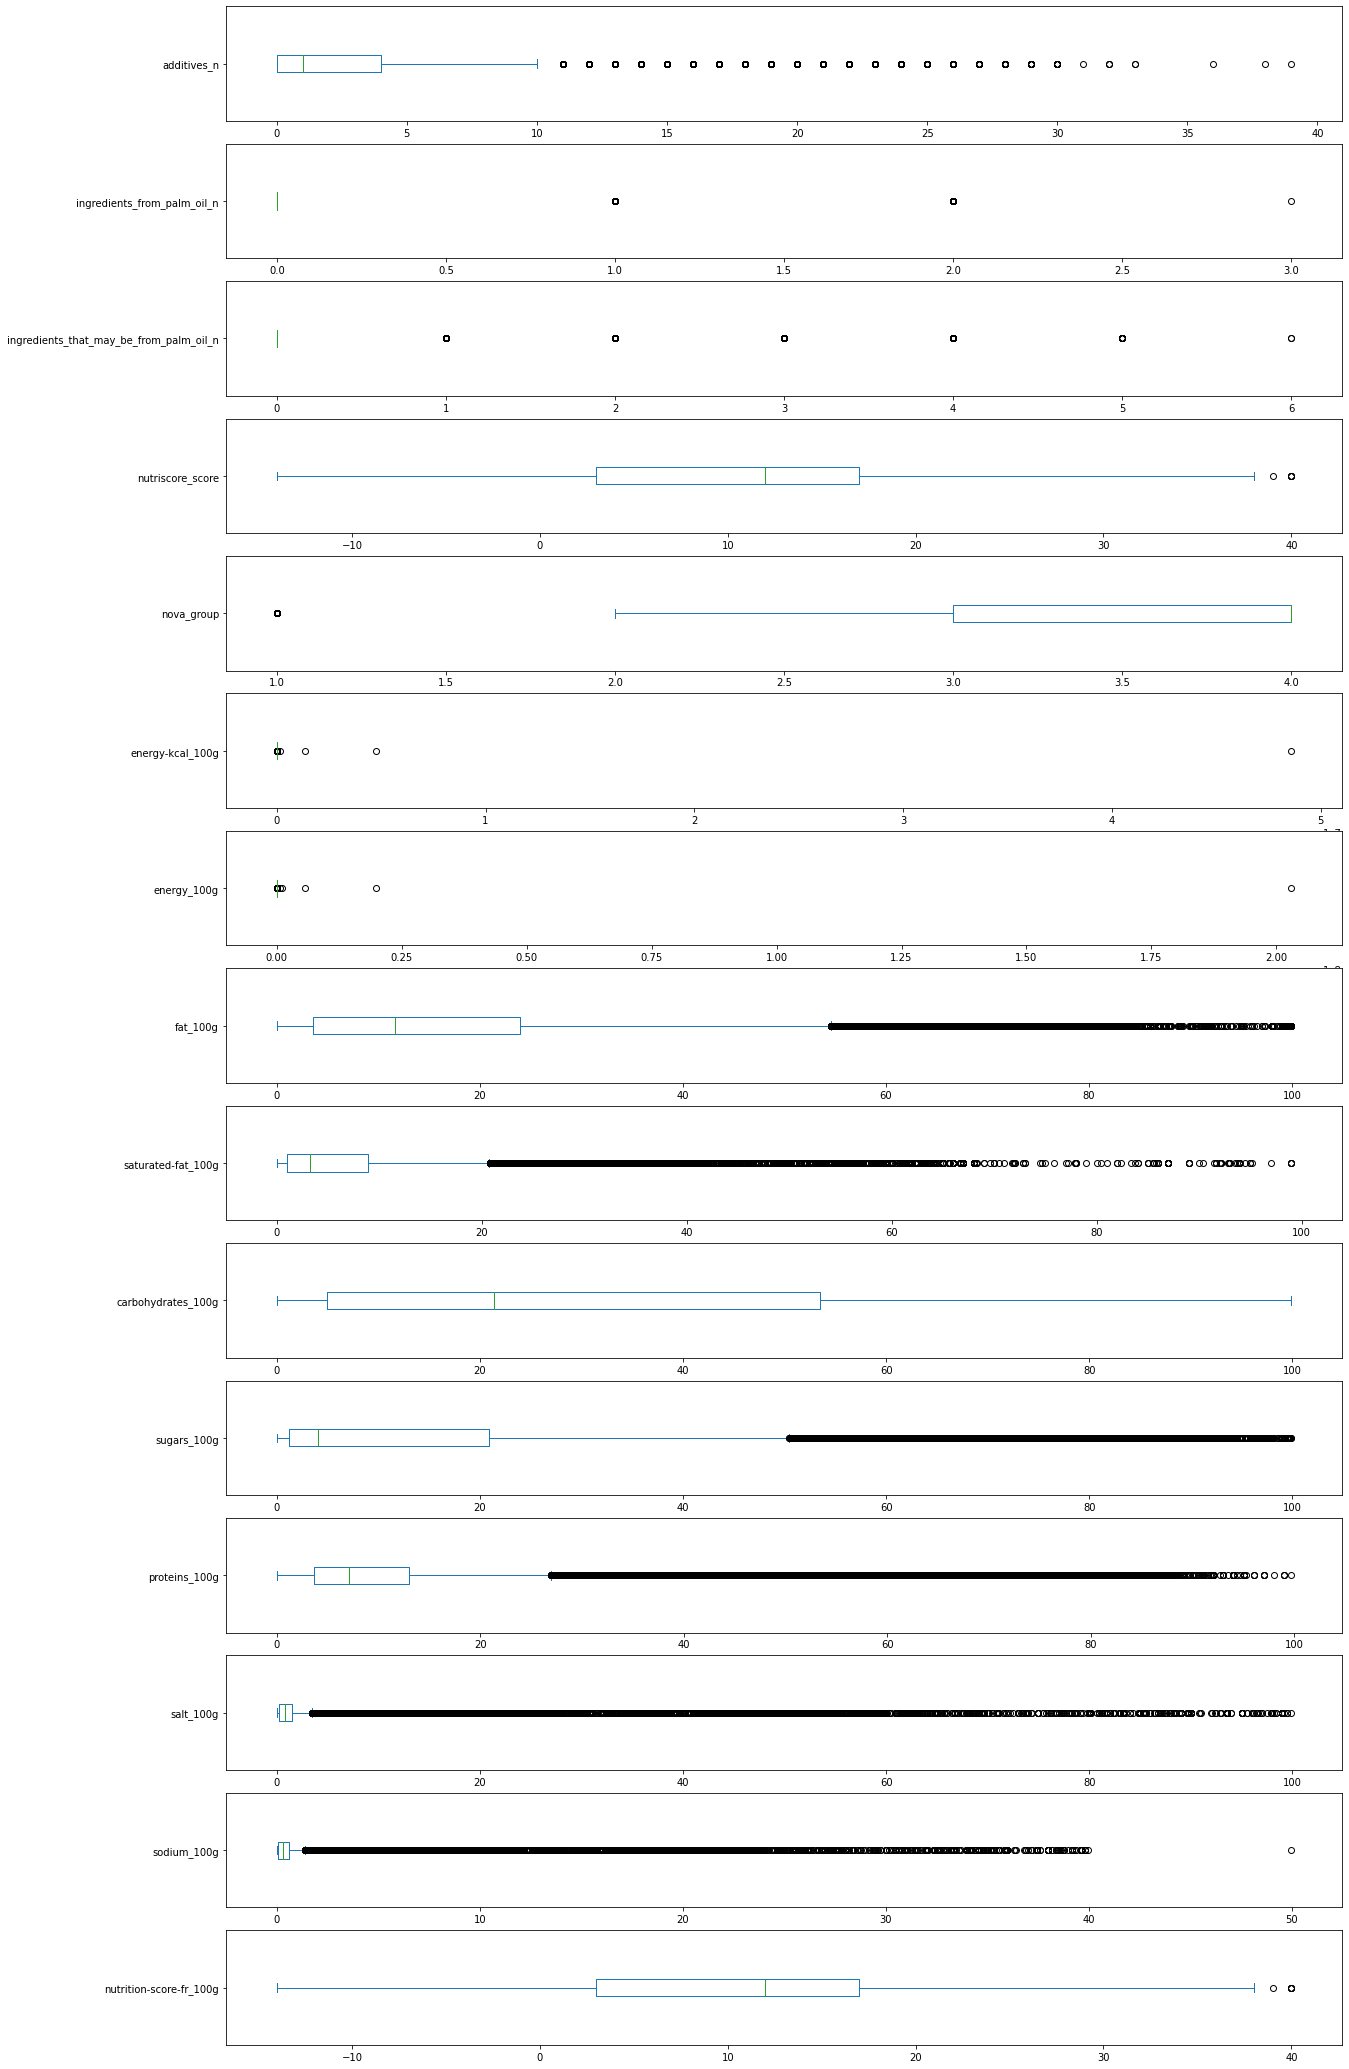

In [10]:
plotBoxes(df, df.select_dtypes('float').columns)

We see that in fact, almost all of the quantitative features have outliers, so we'll have to remove them

some others are in fact categorical features:
* nova_group
* ingredients_from_palm_oil_n
* ingredients_that_may_be_from_palm_oil_n

We should convert them to panda.categories for convenience

Some others are not continuous values:
* additives_n

All the others, we can be confident to replace NaN values by number 0.0

In [45]:
df['nova_group'] = df['nova_group'].astype('category')
df['ingredients_from_palm_oil_n'] = df['ingredients_from_palm_oil_n'].astype('category')
df['ingredients_that_may_be_from_palm_oil_n'] = df['ingredients_that_may_be_from_palm_oil_n'].astype('category')

In [53]:
quantis_continuous = quantis.drop(['nova_group','ingredients_from_palm_oil_n', 'ingredients_that_may_be_from_palm_oil_n', 'additives_n'])
df[quantis_continuous].fillna(value=0.0, inplace=True)

Let's see graphically the distribution of the features

distribution of values


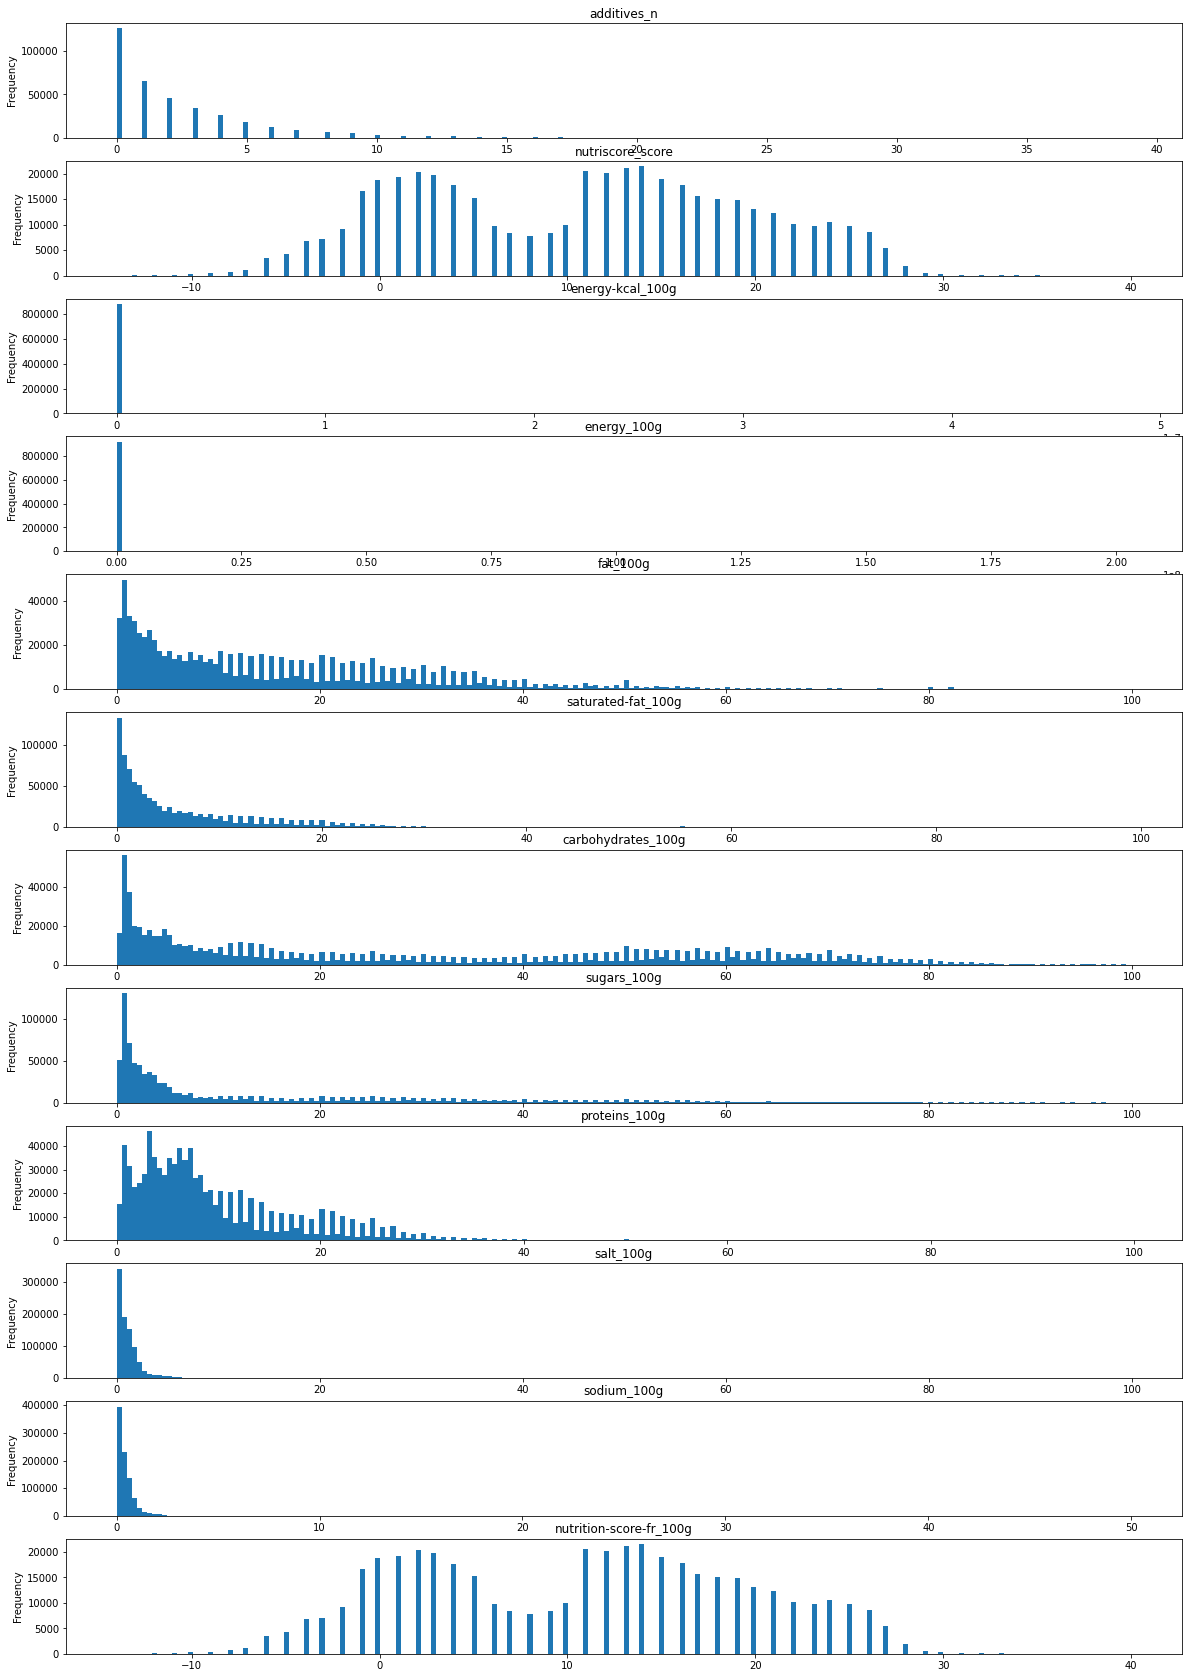

In [57]:
plotDist(df, df.select_dtypes('float').columns)

Reminder, what are the rates of missing values for these features ?

In [13]:
(df.select_dtypes('float').isna().mean().sort_values()) * 100

fat_100g                   0.00
saturated-fat_100g         0.00
carbohydrates_100g         0.00
sugars_100g                0.00
proteins_100g              0.00
salt_100g                  0.00
sodium_100g                0.00
energy_100g                0.04
energy-kcal_100g           3.94
nutrition-score-fr_100g   50.48
nutriscore_score          50.48
additives_n               60.24
dtype: float64

Let's apply our function to remove the outliers

We have implemented two methods in our custom library : Z-Score and IQ Range

Let's consider feature having outliers if they have `std > 10`

We can remove `nutrition-score-fr_100g` since it is almost all empty

In [6]:
df.drop('nutrition-score-fr_100g', axis=1, inplace=True)

********************** TODO voir mes notes apres le meeting avec Ben ****************************

In [7]:
has_Outliers = df.select_dtypes('float').std() > 10
has_Outliers.index[has_Outliers].values

(apply_list_of_funcs pid=214449) 


array(['energy-kcal_100g', 'energy_100g', 'fat_100g',
       'carbohydrates_100g', 'sugars_100g'], dtype=object)

In [118]:
# %run ./module_P2_utils.ipynb

In [8]:
removeOutliers(df, has_Outliers.index[has_Outliers].values)

Now that outliers are removed, let's see the results

let's plot before removing outliers, with good sense

We should apply outliers removal for some

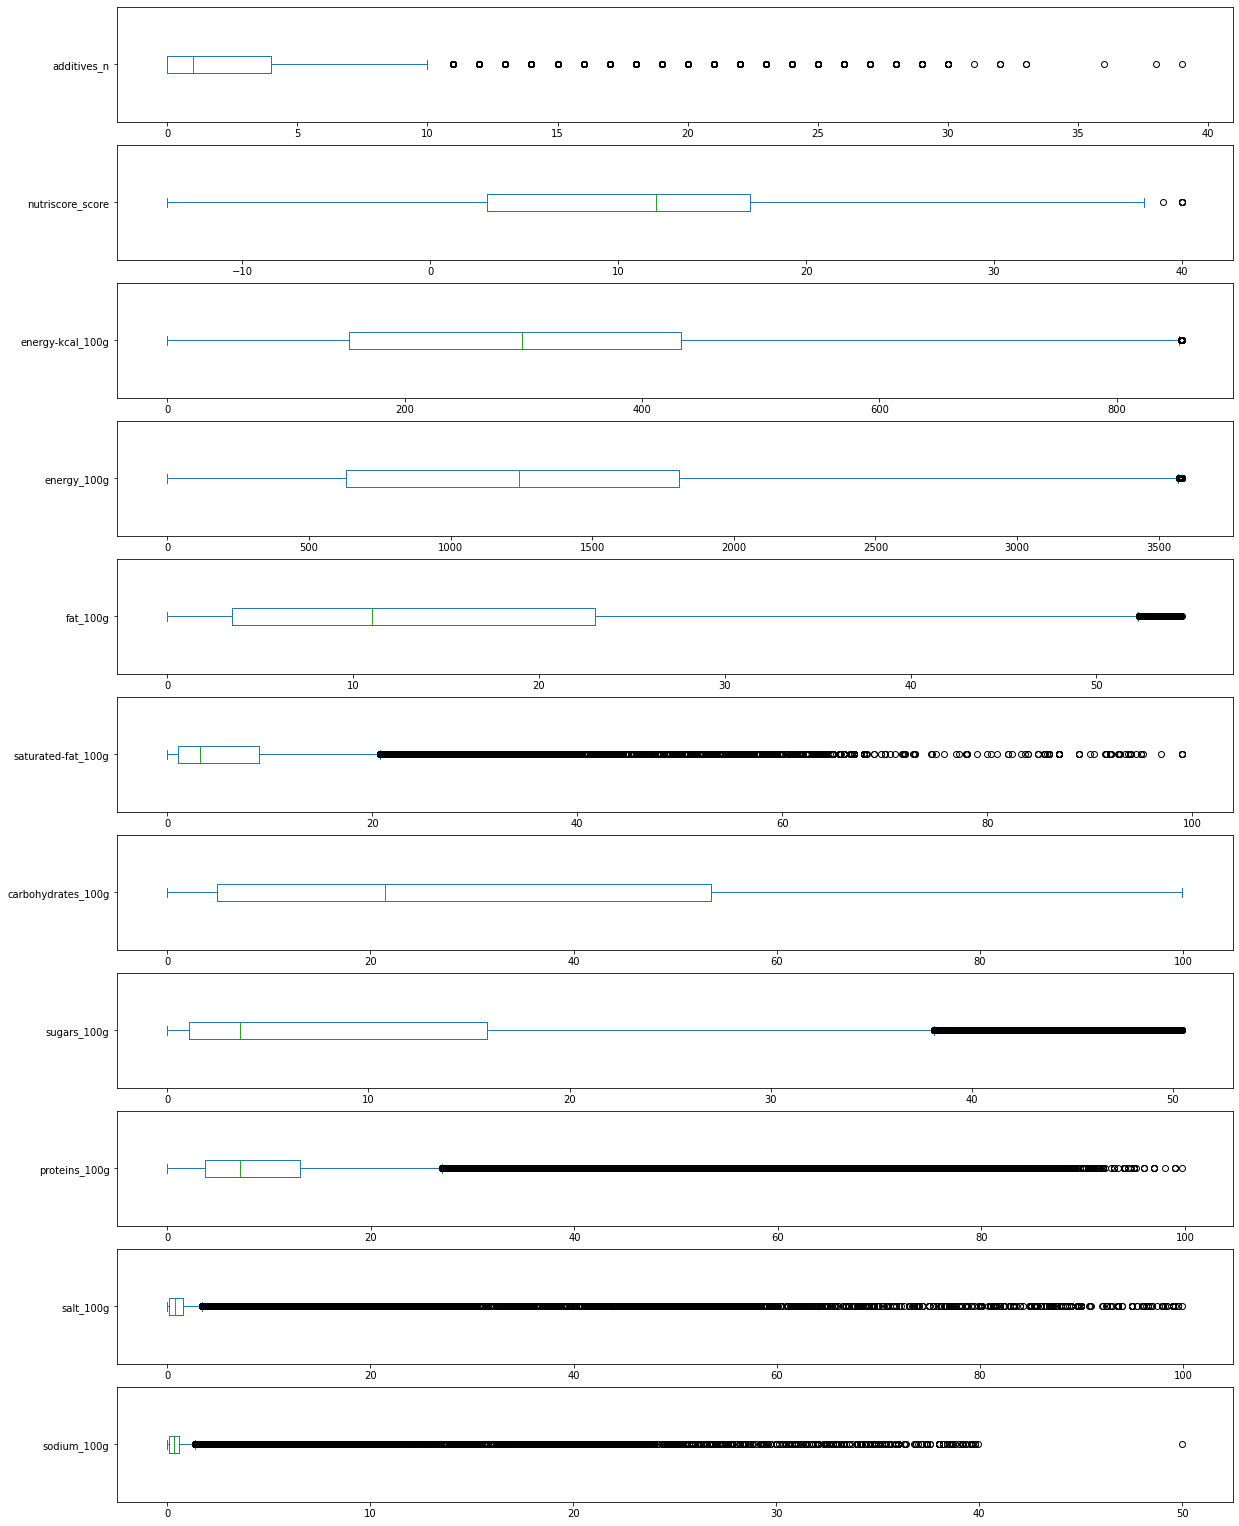

In [9]:
plotBoxes(df, df.select_dtypes('float').columns)

This is way better, despite some outliers are still present.

let's see the distributions

In [10]:
%run ./module_P2_utils.ipynb

distribution of values


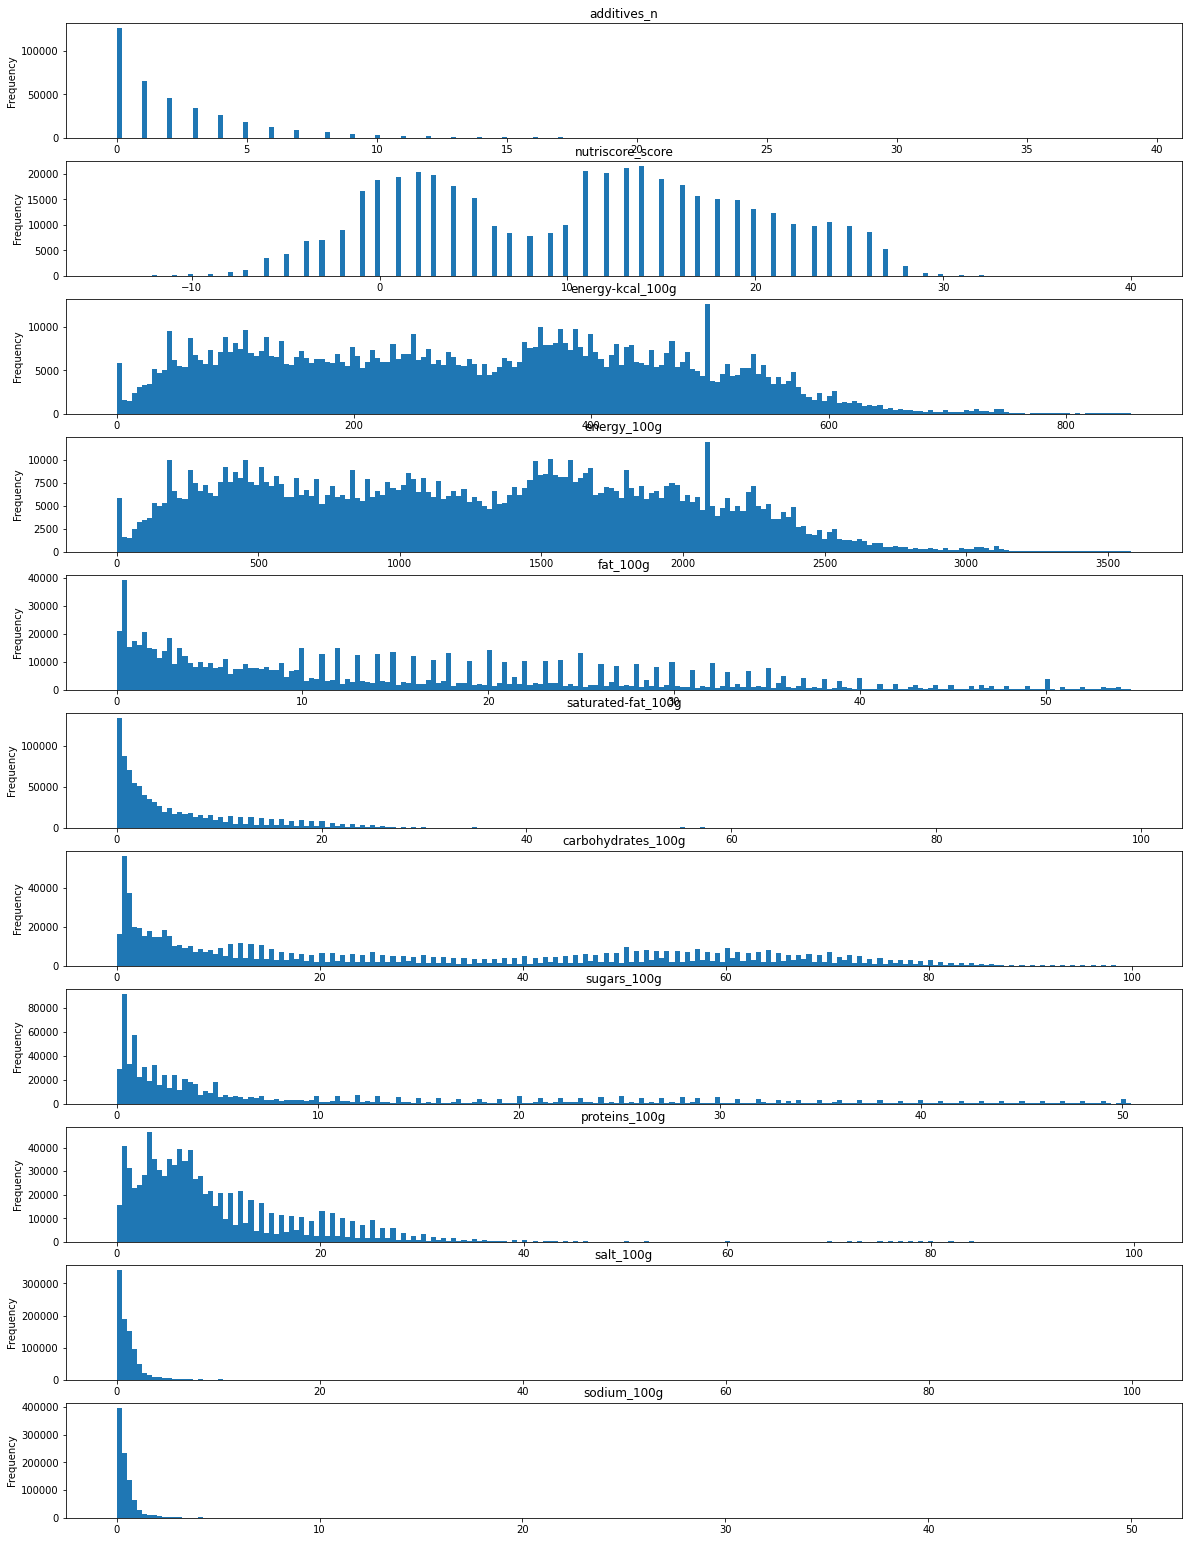

In [18]:
plotDist(df, df.select_dtypes('float').columns)

In [19]:
df.select_dtypes('float').agg(agg_func).T

(apply_list_of_funcs pid=168405) 


,std,skew,kurtosis,mean,median,var,mad,prod,sum
additives_n,3.23,2.31,7.79,2.45,1.00,10.41,2.33,0.00,"894,914.00"
nutriscore_score,8.83,0.01,-1.00,10.65,12.00,77.89,7.57,0.00,"4,836,342.00"
energy-kcal_100g,169.16,0.16,-0.87,300.82,299.00,"28,616.34",144.65,NaN,"263,804,755.50"
energy_100g,708.47,0.17,-0.88,"1,253.29","1,243.00","501,925.06",606.42,NaN,"1,144,116,483.10"
fat_100g,12.72,0.87,-0.03,14.61,11.00,161.87,10.59,inf,"13,166,457.33"
saturated-fat_100g,7.26,2.31,9.29,6.08,3.20,52.67,5.38,inf,"5,578,555.18"
carbohydrates_100g,26.01,0.48,-1.17,29.53,21.43,676.27,23.28,inf,"27,085,846.59"
sugars_100g,12.98,1.43,0.94,10.27,3.60,168.39,10.41,inf,"8,898,515.98"
proteins_100g,9.41,2.87,14.68,9.83,7.10,88.47,6.54,inf,"9,018,557.82"
salt_100g,3.03,14.69,311.66,1.28,0.80,9.18,1.10,0.00,"1,176,993.71"


In [20]:
df.select_dtypes('float').describe().T

,count,mean,std,min,25%,50%,75%,max
additives_n,"364,757.00",2.45,3.23,0.00,0.00,1.00,4.00,39.00
nutriscore_score,"454,252.00",10.65,8.83,-14.00,3.00,12.00,17.00,40.00
energy-kcal_100g,"876,950.00",300.82,169.16,0.00,153.00,299.00,433.00,855.00
energy_100g,"912,894.00","1,253.29",708.47,0.00,632.00,"1,243.00","1,807.00","3,582.00"
fat_100g,"901,295.00",14.61,12.72,0.00,3.50,11.00,23.00,54.60
saturated-fat_100g,"917,304.00",6.08,7.26,0.00,1.00,3.20,8.90,99.00
carbohydrates_100g,"917,304.00",29.53,26.01,0.00,4.90,21.43,53.50,99.90
sugars_100g,"866,355.00",10.27,12.98,0.00,1.10,3.60,15.90,50.44
proteins_100g,"917,304.00",9.83,9.41,0.00,3.70,7.10,13.00,99.70
salt_100g,"917,304.00",1.28,3.03,0.00,0.20,0.80,1.50,99.90


Now the figures are more consistent

In [11]:
df.to_csv("./tmp/df_02_quanti.csv")

## Analysis

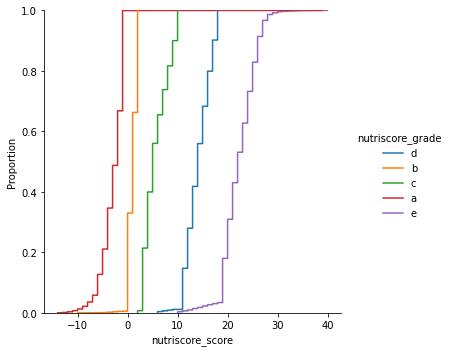

In [9]:
sns.displot(data=df, hue='nutriscore_grade', x='nutriscore_score', kind='ecdf')

Pearson Correlation coefficient

In [10]:
df[['energy_100g', 'nutriscore_score']].corr()

,energy_100g,nutriscore_score
energy_100g,1.000000,0.649138
nutriscore_score,0.649138,1.000000


In [14]:
df.corr()

,Unnamed: 0,additives_n,nutriscore_score,energy-kcal_100g,energy_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,proteins_100g,salt_100g,sodium_100g
Unnamed: 0,1.000000,-0.234352,-0.083733,0.010255,0.010584,-0.047207,-0.044958,0.029927,-0.042764,-0.030429,0.022391,0.022345
additives_n,-0.234352,1.000000,0.228136,0.031612,0.034262,-0.006813,-0.000294,0.147052,0.212114,-0.113651,-0.005282,-0.005369
nutriscore_score,-0.083733,0.228136,1.000000,0.644591,0.649138,0.639315,0.636324,0.296464,0.474927,0.053808,0.163239,0.162691
energy-kcal_100g,0.010255,0.031612,0.644591,1.000000,0.997534,0.726153,0.543098,0.518310,0.380802,0.163550,-0.025045,-0.025046
energy_100g,0.010584,0.034262,0.649138,0.997534,1.000000,0.727457,0.546331,0.521856,0.382603,0.164521,-0.023947,-0.023981
fat_100g,-0.047207,-0.006813,0.639315,0.726153,0.727457,1.000000,0.742479,0.041555,0.206081,0.178929,0.023029,0.022963
saturated-fat_100g,-0.044958,-0.000294,0.636324,0.543098,0.546331,0.742479,1.000000,0.010520,0.235989,0.083149,-0.009974,-0.009992
carbohydrates_100g,0.029927,0.147052,0.296464,0.518310,0.521856,0.041555,0.010520,1.000000,0.585821,-0.240879,-0.094114,-0.094056
sugars_100g,-0.042764,0.212114,0.474927,0.380802,0.382603,0.206081,0.235989,0.585821,1.000000,-0.240076,-0.115195,-0.115075
proteins_100g,-0.030429,-0.113651,0.053808,0.163550,0.164521,0.178929,0.083149,-0.240879,-0.240076,1.000000,0.112275,0.112143


In [11]:
correlations = df.select_dtypes('float').corr(method="pearson")
correlations = np.abs(correlations)
correlations

,additives_n,nutriscore_score,energy-kcal_100g,energy_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,proteins_100g,salt_100g,sodium_100g
additives_n,1.000000,0.228136,0.031612,0.034262,0.006813,0.000294,0.147052,0.212114,0.113651,0.005282,0.005369
nutriscore_score,0.228136,1.000000,0.644591,0.649138,0.639315,0.636324,0.296464,0.474927,0.053808,0.163239,0.162691
energy-kcal_100g,0.031612,0.644591,1.000000,0.997534,0.726153,0.543098,0.518310,0.380802,0.163550,0.025045,0.025046
energy_100g,0.034262,0.649138,0.997534,1.000000,0.727457,0.546331,0.521856,0.382603,0.164521,0.023947,0.023981
fat_100g,0.006813,0.639315,0.726153,0.727457,1.000000,0.742479,0.041555,0.206081,0.178929,0.023029,0.022963
saturated-fat_100g,0.000294,0.636324,0.543098,0.546331,0.742479,1.000000,0.010520,0.235989,0.083149,0.009974,0.009992
carbohydrates_100g,0.147052,0.296464,0.518310,0.521856,0.041555,0.010520,1.000000,0.585821,0.240879,0.094114,0.094056
sugars_100g,0.212114,0.474927,0.380802,0.382603,0.206081,0.235989,0.585821,1.000000,0.240076,0.115195,0.115075
proteins_100g,0.113651,0.053808,0.163550,0.164521,0.178929,0.083149,0.240879,0.240076,1.000000,0.112275,0.112143
salt_100g,0.005282,0.163239,0.025045,0.023947,0.023029,0.009974,0.094114,0.115195,0.112275,1.000000,0.999071


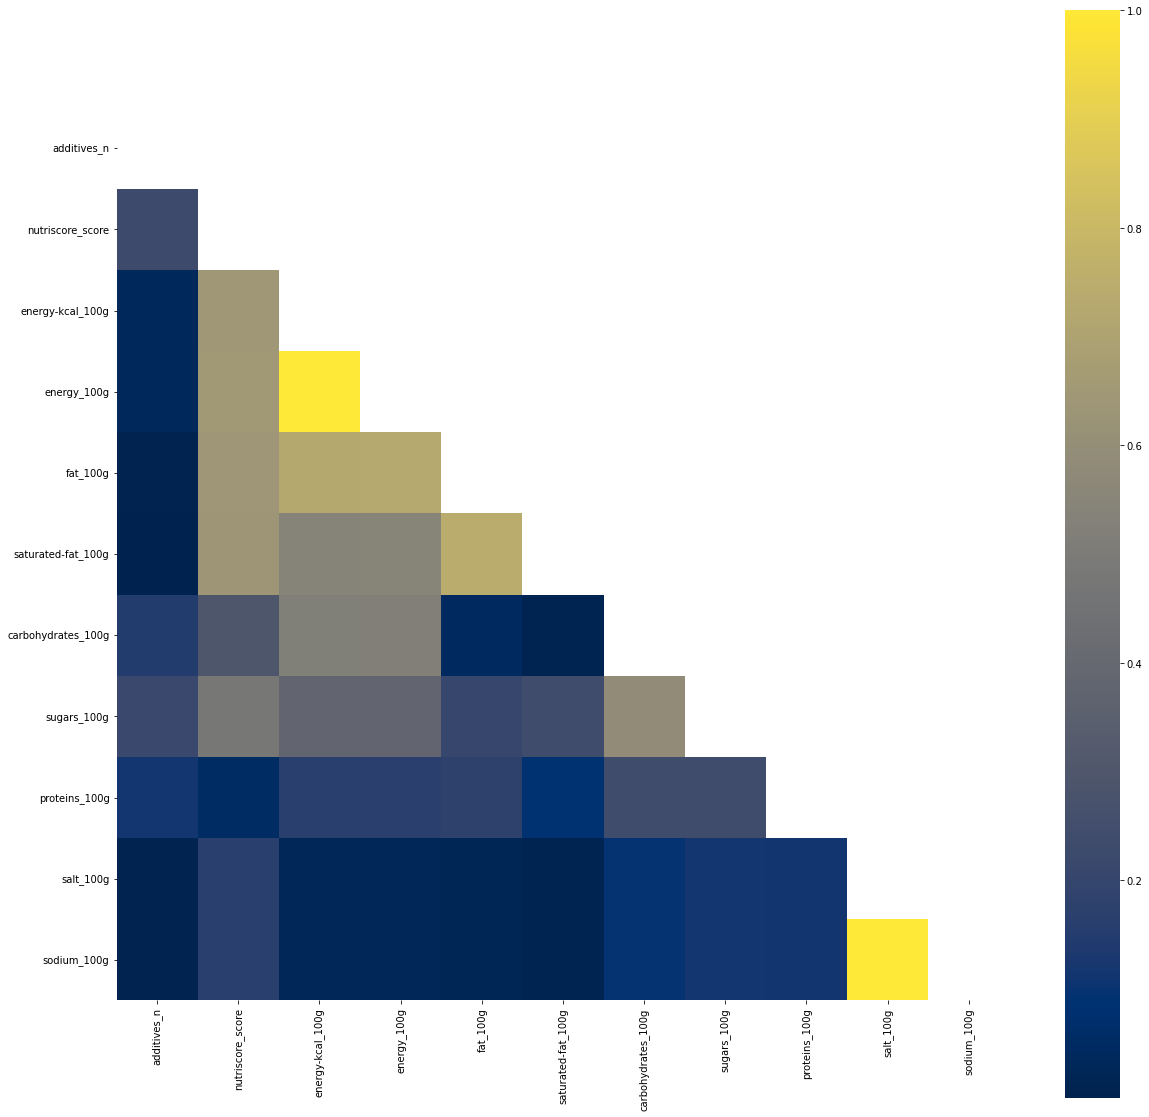

In [24]:
mask = np.zeros_like(correlations)
mask[np.triu_indices_from(mask)] = True
sns.axes_style("white")
f, ax = plt.subplots(figsize=(20,20))
ax = sns.heatmap(correlations, mask=mask, vmax=1, square=True, xticklabels=correlations.columns, yticklabels=correlations.columns, cmap='cividis')
# ax = sns.heatmap(correlations, square=True, xticklabels=correlations.columns, yticklabels=correlations.columns)


In [ ]:
# snippet de Ben
# correlations = cleanDataF.filter(items=columnsToBeFiltered).corr(method="pearson")
# f, ax = plt.subplots(figsize = (40, 40))
# #regarder la distance par défault dans heatmapa
# figure = sns.heatmap(correlations, annot = True).get_figure()
# figure.savefig("./Visuals/originalDFheatmap.jpg")

AttributeError: 'numpy.ndarray' object has no attribute 'boxplot'

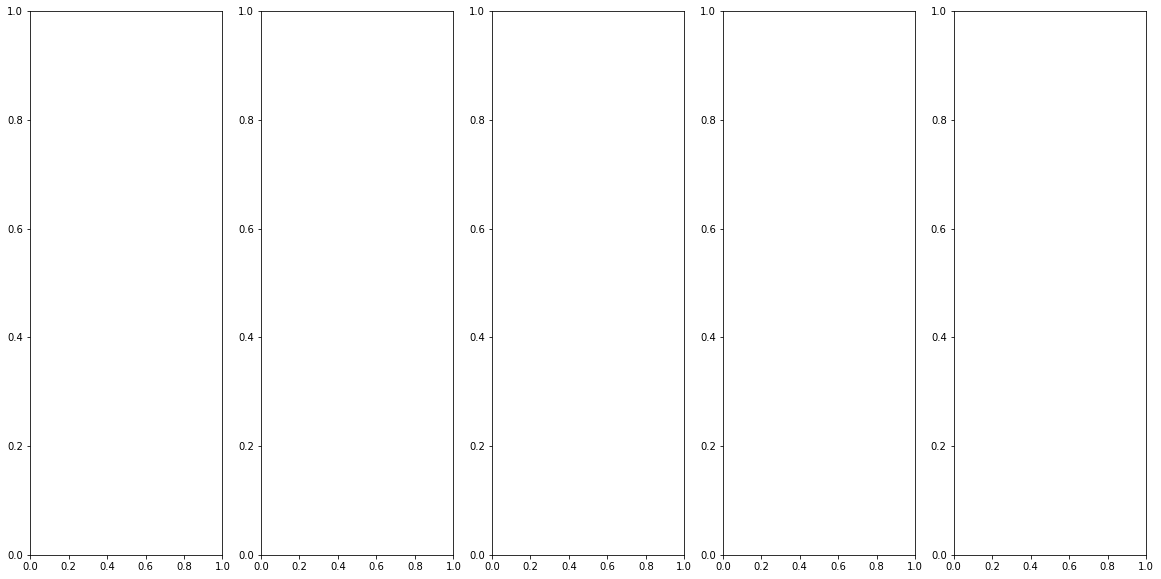

In [25]:
grades = df['nutriscore_grade'].dropna().unique()
fig, ax = plt.subplots(1, grades.size, figsize=(20,10))
for i, g in enumerate(grades):
    ax.boxplot(df[df.nutriscore_grade == g]['energy_100g'].dropna().values , showfliers=False)
    ax.set_title(g, fontsize=20, fontweight='bold')

In [26]:
# TODO : dessiner le graphe de correlation, en reduisant les valeurs car sinon trop grand fail
# plt.plot(df.energy_100g, df.nutriscore_score)

In [ ]:
pd.DataFrame({'columns': df.columns, 'multimode': getMultiModes(df, df.columns)})

In [ ]:
df['energy_100g'].agg(["skew", "kurtosis"])

In [ ]:
isMultiMode(df, 'energy_100g')

Despite feature is uni mode, skew is positive and high, so Z-score method cannot be applied here

Therefore we prefer to apply IQR method.


## Quantile Analysis



### Basic Quantile analysis

In [ ]:
df['energy_100g_qc'] = pd.qcut(df['energy_100g'], q=10)
df['energy_100g_qc'].head()

In [ ]:
df['energy_100g_qc'].value_counts()

In [ ]:
df['energy_100g_qc'].head()

https://towardsdatascience.com/ways-to-detect-and-remove-the-outliers-404d16608dba

#### IQR

In [ ]:
df['energy_100g'] = df_bck['energy_100g']

In [ ]:
df['energy_100g'].describe()

In [ ]:
df['energy_100g'].plot(kind='box', vert=False)

Remove outliers following 'IQR' method

In [ ]:
dropOutlierIQR(df, 'energy_100g')

In [ ]:
df['energy_100g'].describe()

In [ ]:
df['energy_100g'].agg(["min", "max", "median", "mean", "var", "std", "skew", "kurtosis"]).T

In [ ]:
df['energy_100g'].plot(kind='box', vert=False)

We have very rare outstanding values, so they can be classified as outliers (outliers must be rare, otherwise question of interest in the dataset must be set). They won't have statiscial impact

what to do with outliers ?
* remove lines
* replace w/ Least Absolute Deviation Method
* replace w/ Robust Statistical Method
* replace by Least Squares Method


In [ ]:
df['energy_100g'].dropna().plot(kind='hist', bins=100)

Implementation of outliers removal based on IQR method

## TODO :
SI la variance / ecart type sont tres grands (rapport ) quoi ?) alors on applique la suppression des outliers

In [ ]:
dropOutliersIQR(df, ['energy_100g', 'energy-kcal_100g', 'fat_100g',
                     'saturated-fat_100g',
                     'carbohydrates_100g',
                     'sugars_100g',
                     'proteins_100g',
                     'salt_100g',
                     'sodium_100g' ])

In [ ]:
dropOutliersZscore(df, ['energy_100g', 'energy-kcal_100g', 'fat_100g',
                        'saturated-fat_100g',
                        'carbohydrates_100g',
                        'sugars_100g',
                        'proteins_100g',
                        'salt_100g',
                        'sodium_100g' ])

# Testing Functions

In [ ]:
df['sodium_tmp'] = df['sodium_100g']

In [ ]:
stats_desc(df['sodium_100g'])

In [ ]:
df['sodium_100g'].plot(kind='hist')

In [ ]:
df['sodium_100g'].plot(kind='box', vert=False)

In [ ]:
%run ./module_P2_utils.ipynb

In [ ]:
isMultiMode(df, 'sodium_100g')

In [ ]:
removeOutlier(df, 'sodium_100g')

In [ ]:
stats_desc(df['sodium_100g'])

In [ ]:
dropOutlierZscore(df, 'sodium_100g')

In [ ]:
dropOutlierIQR(df, 'sodium_100g')

In [ ]:
df['sodium_100g'] = df['sodium_tmp']

## Analysis

In [2]:
sns.displot(df, x='nutriscore_score', hue='nutriscore_grade', kind='ecdf')

NameError: name 'df' is not defined

In [ ]:
pd.crosstab(df['nutriscore_grade'], df['pnns_groups_1'] )

In [ ]:
pd.crosstab(df['nutriscore_grade'], df['pnns_groups_2'] )

In [ ]:
plt.figure(figsize=(20,20))
# sns.displot(df, x='nutriscore_grade')
sns.displot(df, x='nutriscore_score', hue='nutriscore_grade', kind='ecdf')
plt.savefig("nutriscore_grade_multivariate_analysis.png", format='png', dpi=150)
sns.displot(df, x='nutriscore_score', y='ecoscore_score_fr', hue='nutriscore_grade')
# sns.displot(df, x='nutriscore_score', y= 'nova_group', hue='nutriscore_grade', kind='kde')
# sns.displot(df, x='nutriscore_score', col='nutriscore_grade')
plt.savefig("nutriscore_ecoscore_multivariate_analysis.png", format='png', dpi=150)

In [ ]:
df['nutriscore_grade'].value_counts(normalize=True).plot.pie()

In [ ]:
df['nutriscore_score'].dropna().value_counts().sort_values(ascending=False)


We can see that some columns still have lots of empty values, but also that several rows have almost (or all) the features provided,
which is good for further analysis



In [ ]:
# most filled features
df.columns[[0, 1, 11, 12, 13, 25, 26, 27, 28, 29]]

In [ ]:
df.columns.get_loc('nutriscore_grade')